In [160]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


0. Загрузка данных
-----------

Эту часть можно пропустить, результаты будут ниже.


Тренировочные и тестовые данные загружаются в словари словарей `data_train` и `data_test` соответственно

In [161]:
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style('white')
import folder_handling as fh
import os
import glob
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2

In [162]:
import nearest_neighbour as nn
reload(nn)

<module 'nearest_neighbour' from 'nearest_neighbour.pyc'>

In [163]:
path = "../../images/color_experiments/experiment_3/no_lightening/"

In [164]:
def load_images(path,type_to_load="train"):
    path_indicators = fh.get_path_contents(path)
    
    data = OrderedDict()
    for pi in path_indicators:
        data[os.path.basename(pi)] = OrderedDict()
        
        for illum in fh.get_path_contents(pi):
            data[os.path.basename(pi)][os.path.basename(illum)] = OrderedDict()
            for gradation in fh.get_path_contents(os.path.join(illum,type_to_load)):
                img = cv2.imread(gradation)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                name = os.path.splitext(os.path.basename(gradation))[0]
                data[os.path.basename(pi)][os.path.basename(illum)][name] = img
                
    return data

In [165]:
data_train = load_images(path)

In [166]:
data_test = load_images(path,type_to_load="test")

1. Тренировочные и тестовые картинки
--------------------

Ниже выведены все картинки, которые были взяты в тренировочный и в тестовый набор. Это такие типы индикаторов, как LEU, NIT, URO, PRO, BLO

In [167]:
def plot_all_images():
    for ind_type in data_train:
        for illumination_name,images in data_train[ind_type].iteritems():
            plt.figure(figsize=(12,2))
            for i,(class_name,img) in enumerate(images.iteritems()):
                plt.subplot(1,len(images),i+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(class_name)

            plt.suptitle('{} {} train'.format(ind_type,illumination_name))

            plt.figure(figsize=(12,2))
            images_test = data_test[ind_type][illumination_name]
            for i,(class_name,img) in enumerate(images_test.iteritems()):
                plt.subplot(1,len(images_test),i+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(class_name)
            plt.suptitle('{} {} test'.format(ind_type,illumination_name))
    plt.show()

In [168]:
#plot_all_images()

2. Алгоритм распознавания 
------------------

Была предложена идея распознавать цвет на тестовом изображении с помощью метрического алгоритма одного ближайшего соседа - т.е. искать в тренировочном наборе, относящемся к тому же типу освещенности и индикатору, что и тестовое изображение, ближайшую картинку.


### Описание функций:

В данном файле представлена версия алгоритма ближайшего соседа, взятая из ноутбука **col_exp_3.ipynb**.

 - Проработана реализация метрики: функции типа <font color = 'blue'>**get_distance**</font> берёт на вход две картинки -> и считает по ним метрику.
 
 - добавлена функция <font color='blue'>**preprocessing**</font>, которая принимает в качестве аргумента изображение и возвращает изображение.
 
 - функция <font color='blue'>**one_nearest_neighbor**</font> принимает на вход словарь `train_images` со значениями {класс : изображение}, `test_image`, функцию  <font color = 'blue'>**get_distance**</font>, <font color='blue'>**preprocessing**</font>:
 
 * после чего происходит предобработка тестового изображения и тренировочных, а затем применяется алгоритм поиска ближайшего соседа

### Что хочется попробовать: 
 
 
В качестве признаков для обучающего и тестового набора изображений были выбраны:

- средние значения по каналам RGB
- медианные значения по каналам RGB
- средние значения по каналам LAB
- медианные значения по каналам LAB
- некоторые алгоритмы предобработки тестовых и обучающих изображений - Гауссовы фильтры, бокс-фильтры

In [266]:

def wise_mean(img):
    means = np.zeros(3)
    for i in xrange(3):
        channel = img[:,:,i]
        p95 = np.percentile(channel,100)
        p5 = np.percentile(channel,0)
        means[i] = np.mean(channel[(channel>=p5)&(channel<=p95)])
    return means


def get_distance(img1,img2):
        
    point1 = wise_mean(img1)
    point2 = wise_mean(img2)
    d = 0.
    for i in xrange(point1.shape[0]):
        d += (point1[i] - point2[i])**2
            
    return np.sqrt(d)
 
def get_manhattan_distance(img1,img2):
    
    point1 = wise_mean(img1)
    point2 = wise_mean(img2)
    d = 0.
    
    for i in xrange(point1.shape[0]):
        d += np.abs(point1[i] - point2[i])
        
    return d

def get_frobenius_distance(img1,img2):
    if img1.shape[0]<=img2.shape[0]:
        i,j,k = img1.shape
        
        img2 = cv2.resize(img2, img1.shape[:2])
    else:
        i,j,k = img2.shape
        
        img1 = cv2.resize(img1, img2.shape[:2])
        
    
    return np.linalg.norm(img1-img2)



### Тестирующий класс:
   - содержит **поля**:
       - ``mistakes_strict`` - список с ошибочными объектами при строгом отборе 
       - `mistakes_soft` - список с ошибочными объектами при мягком отборе (отклонение в классе не более чем на 1)
       - `well_predicted_strict` - вспомогательные поля - правильно ли предсказана метка класса при строгом отборе
       - `well_predicted_soft` - вспомогательные поля - хорошо или плохо сделана классификация при мягком отборе
       - `prob_mistakes` - распределение вероятностей класса на ошибочно предсказанных объектах при строгом отборе
   - **методы**:
       - <font color = 'blue'> test </font>: (data_train,data_test,get_distance,preprocessing): тестирует нужную функцию
       - <font color = 'blue'> get_acc_strict </font>: возвращает точность при строгом отборе
       - <font color = 'blue'> get_acc_soft </font>: возвращает точность при мягком отборе
       - <font color = 'blue'> get_mistakes_strict</font>: возвращает список ошибок
       - <font color = 'blue'> get_mistakes_soft</font>: возвращает список ошибок
       - <font color = 'blue'> print_report</font>: печатает отчёт о тесте

In [268]:
img = data_train['BLO']['illum_1']['3']

In [311]:
import tqdm

In [319]:
###Example of grid search
"""
coefs = []
for i in xrange(1,6):
    for j in xrange(1,6):
        for k in xrange(1,6):
            coefs.append(np.array([i,j,k]))
            
tester = nn.TestDistancePreprocessing()

train = {x: data_train[x] for x in data_train if x!='BLO'}
test = {x: data_test[x] for x in data_test if x!='BLO'}

color_spaces = {'RGB':'None',
                'YUV':cv2.COLOR_RGB2YUV,
                'YCrCb':cv2.COLOR_RGB2YCrCb,
                'XYZ':cv2.COLOR_RGB2XYZ,
                'LUV':cv2.COLOR_RGB2LUV,
                #'Luv':cv2.COLOR_RGB2Luv,
                #'Lab':cv2.COLOR_RGB2Lab,
                'LAB':cv2.COLOR_RGB2LAB}
                #'HLS':cv2.COLOR_RGB2HLS}

space_vs_strictacc = {}
space_vs_softacc = {}
for name,color_space in tqdm.tqdm_notebook(color_spaces.iteritems()):

    strict_accs = []
    soft_accs = []
    for coef in tqdm.tqdm_notebook(coefs,leave=False): 
        def get_distance(img1,img2):

            point1 = wise_mean(img1)
            point2 = wise_mean(img2)
            d = 0.


            for i in xrange(point1.shape[0]):
                d += coef[i]*np.abs(point1[i] - point2[i])**2

            return np.sqrt(d)



        def preprocessing(img):
            img = cv2.blur(img,(5,5))
            if color_space == 'None':
                return img
            return cv2.cvtColor(img,color_space)

        tester.test(data_train=train,data_test=test,
                    get_distance=get_distance,
                    preprocessing=preprocessing)

        soft_accs.append(tester.get_acc_soft())
        strict_accs.append(tester.get_acc_strict())
        
    space_vs_strictacc[name] = strict_accs
    space_vs_softacc[name] = soft_accs""" 
pass

LUV 0.821052631579
XYZ 0.663157894737
LAB 0.852631578947
YUV 0.852631578947
YCrCb 0.842105263158
RGB 0.705263157895


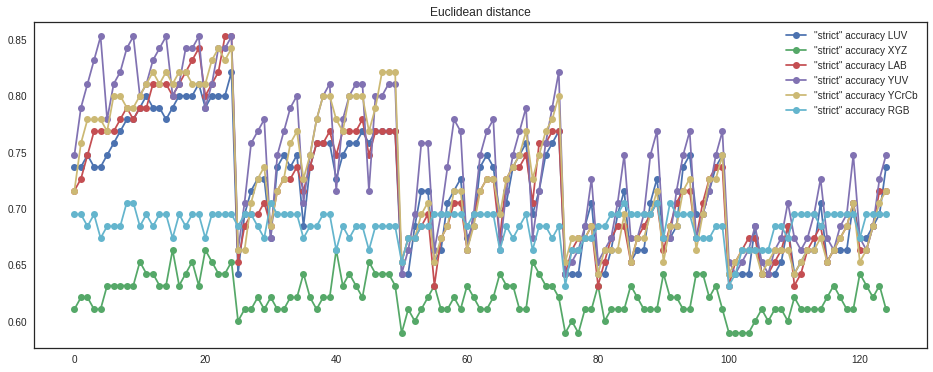

In [317]:
plt.figure(figsize=(16,6))
for space,strict_accs in space_vs_strictacc.iteritems():
    plt.plot(strict_accs,'o-',label='"strict" accuracy {}'.format(space))
    print space,np.max(strict_accs)
plt.legend(loc='best')
plt.title('Euclidean distance')

In [318]:
tester.print_report()

Точность в предсказании верного класса:
 69.0 %
Точность в предсказании класса с отклонением не более: 1
 100.0 %


In [277]:
tester.plot_mistakes_soft()

There are no images :)


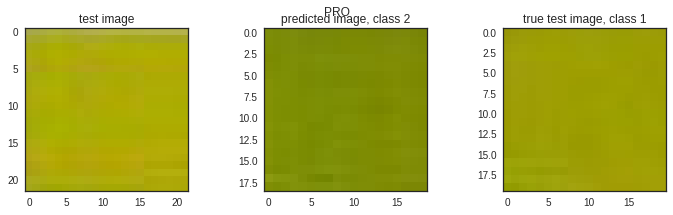

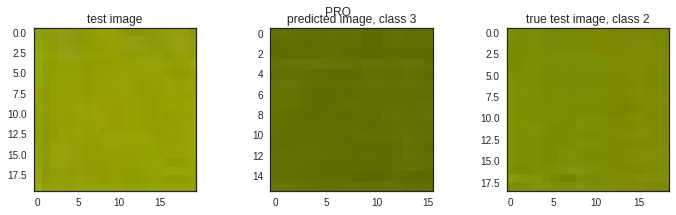

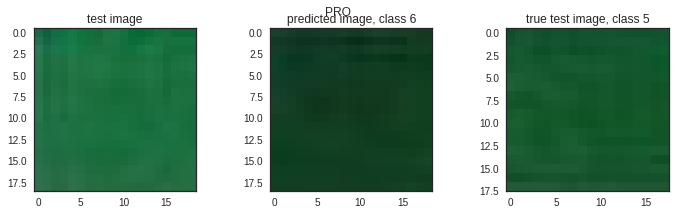

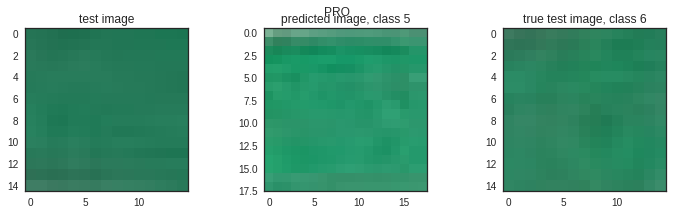

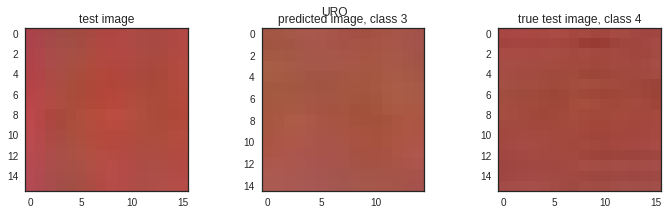

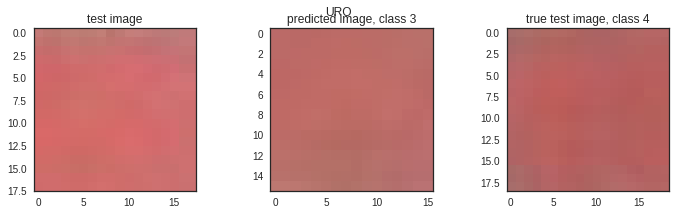

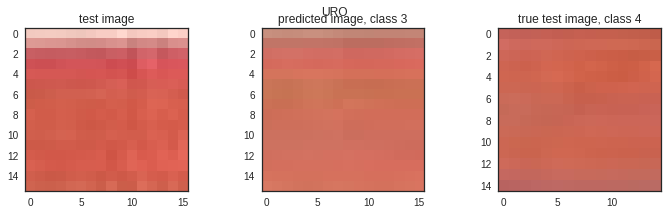

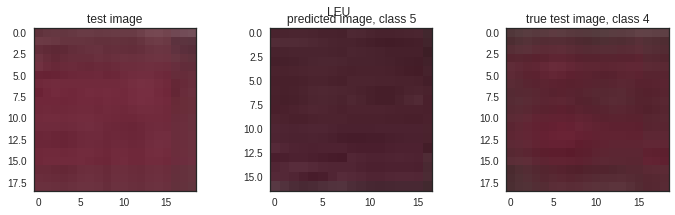

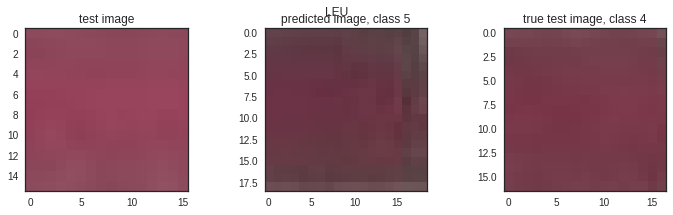

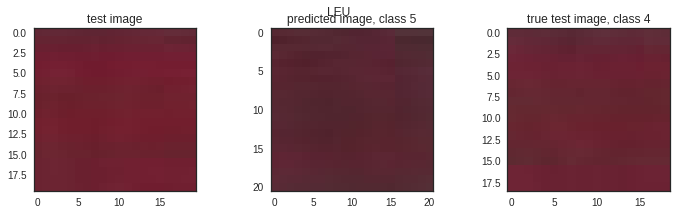

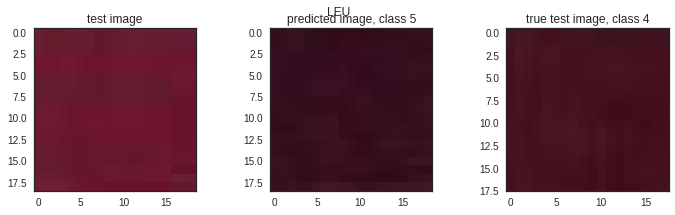

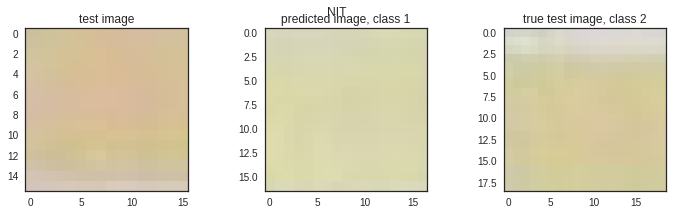

In [278]:
tester.plot_mistakes_strict()

In [226]:
"""for item in tester.mistakes_strict:
    indicator_type, illumination, true_class, predicted_class = [x.split(':')[-1] for x in item]
    
    train_images = data_train[indicator_type][illumination]
    test_image = data_test[indicator_type][illumination][true_class]
    predicted_class = nn.one_nearest_neighbor(train_images,test_image,
                           get_distance=get_frobenius_distance,
                           preprocessing=preprocessing,
                           verbose=True)
    print predicted_class
    
    """
pass

In [39]:
indicator_type = 'BLO'
illumination_name = 'illum_3'
true_class = '3'
test_img = data_test[indicator_type][illumination_name][true_class]

train_images = data_train[indicator_type][illumination_name]

print "predicted class:",nn.one_nearest_neighbor(train_images,test_img,
                                             preprocessing=preprocessing,
                                             get_distance=get_distance)

print "true class:",true_class

predicted class: 2
true class: 3


# Результаты

## Эксперимент 1.
- Переход в HSV и евклидова метрика с подсчётом среднего в качестве признаков: 
   - Точность в предсказании верного класса
        73.1 %
        Точность в предсказании класса с отклонением не более 1
        96.2 %
         
- Переход в HSV и манхеттенское расстояние и среднее:
    - Точность в предсказании верного класса
         76.9 %
        Точность в предсказании класса с отклонением не более 1
         96.9 %
- Переход в HSV, manhattan, median: 
    - Точность в предсказании верного класса
         76.2 %
        Точность в предсказании класса с отклонением не более 1
         97.7 %
- LAB, Euclidean, median: 
    - Точность в предсказании верного класса
 71.5 %
    Точность в предсказании класса с отклонением не более 1
    98.5 %
- LAB, Euclidean, mean:
    - Точность в предсказании верного класса
 70.8 %
    Точность в предсказании класса с отклонением не более 1
    99.2 %
    
- LAB, manhattan, mean:
    - Точность в предсказании верного класса
 76.2 %
    Точность в предсказании класса с отклонением не более 1
     99.2 %
- LAB, manhattan, median:
    - Точность в предсказании верного класса
 74.6 %
    Точность в предсказании класса с отклонением не более 1
     98.5 %
- XYZ, manhattan or Euclidean, mean: 
    - Плохо - 60 %, 95%

Вывод: кажется, тип статистики, применяемый к цветовому каналу не сильно изменяет качество классификации, в то время как метрика, цветовое пространство (и др. предобработка) значительно влияют на качество классификации.
    
## Эксперимент 2.

Были проведен следующий эксперимент: 
для манхэттенского расстояния подбирались коэффициенты $c_i$ в манхэттенской метрике
$$\rho_1 (a,b) = \sum_{i}^{3}c_i*|a_i - b _i|$$ и евклидовой метрике
$$\rho_2 (a,b) = \sqrt{\sum_{i}^{3}c_i*(a_i - b _i)^2}$$
где a, b - векторы средних значений цветовых каналов изображения.

Перед этим изображение переводилось в одно из цветовых пространств: LUV, XYZ, LAB,YUV,YCrCb,RGB. 

- Для $\rho_1$ получились следующие значения точности:
    - LUV 0.842105263158
    - XYZ 0.663157894737
    - **LAB 0.873684210526**
    - YUV 0.852631578947
    - YCrCb 0.842105263158
    - RGB 0.705263157895
    
- Для $\rho_2$ получились следующие значения точности:
    - LUV 0.821052631579
    - XYZ 0.663157894737
    - **LAB 0.852631578947**
    - **YUV 0.852631578947**
    - YCrCb 0.842105263158
    - RGB 0.705263157895

Оценка точности проводилась по data_train и data_test без индикатора 'BLO'